In [80]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [81]:
customers = pd.read_csv("/content/Customers.csv")
transactions = pd.read_csv("/content/Transactions.csv")

In [82]:
merged_data = pd.merge(transactions, customers, on="CustomerID")


In [83]:
customer_agg = merged_data.groupby("CustomerID").agg({
    'Quantity': 'sum',
    'TotalValue': 'sum'
}).reset_index()

In [84]:
final_data = pd.merge(customer_agg, customers, on="CustomerID")


In [85]:
final_data_numeric = final_data.drop(columns=['CustomerID', 'CustomerName', 'Region', 'SignupDate'])


In [86]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(final_data_numeric)


In [87]:
linkage_matrix = linkage(data_scaled, method='ward')


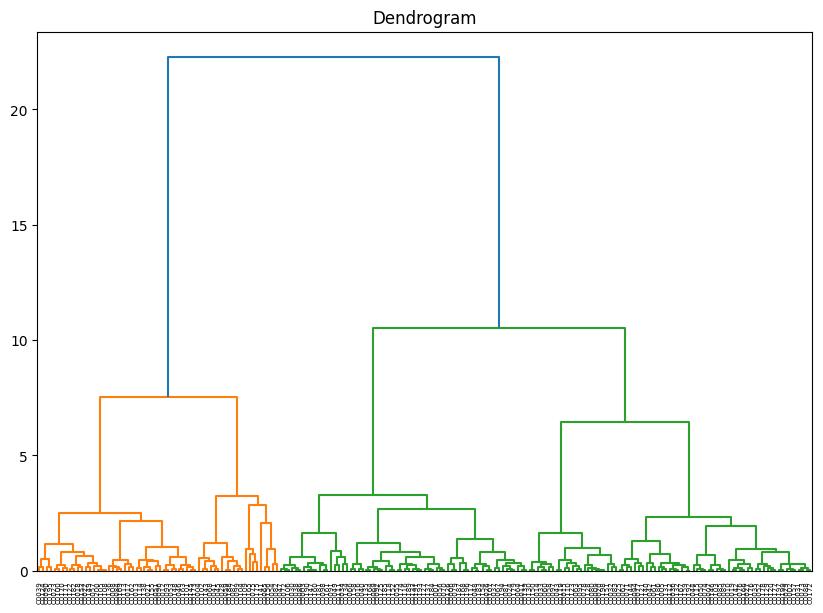

In [88]:
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dendrogram(linkage_matrix, labels=final_data['CustomerID'].values, leaf_rotation=90)
plt.show()

In [89]:
num_clusters = 5


In [90]:
clustering_model = AgglomerativeClustering(n_clusters=num_clusters, metric='euclidean', linkage='ward')
final_data['Cluster'] = clustering_model.fit_predict(data_scaled)


In [91]:
db_index = davies_bouldin_score(data_scaled, final_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 0.7567672920372589


In [92]:
silhouette_avg = silhouette_score(data_scaled, final_data['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

def calculate_intra_cluster_variance(data, labels, centroids):
    intra_variance = 0
    for cluster in range(len(centroids)):
        cluster_points = data[labels == cluster]
        intra_variance += np.sum((cluster_points - centroids[cluster]) ** 2)
    return intra_variance / len(data)

cluster_centers = np.array([data_scaled[final_data['Cluster'] == i].mean(axis=0) for i in range(num_clusters)])

intra_cluster_variance = calculate_intra_cluster_variance(data_scaled, clustering_model.labels_, cluster_centers)
print(f"Intra-Cluster Variance: {intra_cluster_variance}")

Silhouette Score: 0.4226778448438481
Intra-Cluster Variance: 0.23153216111321015


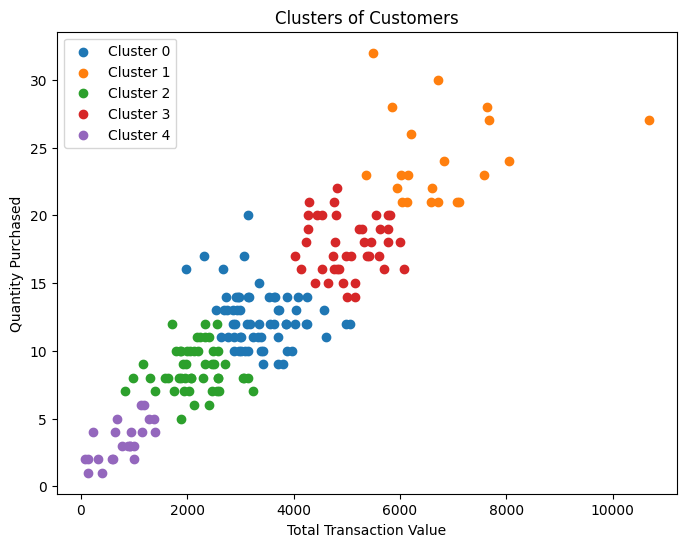

In [93]:
plt.figure(figsize=(8, 6))
for cluster in range(num_clusters):
    cluster_data = final_data[final_data['Cluster'] == cluster]
    plt.scatter(cluster_data['TotalValue'], cluster_data['Quantity'], label=f"Cluster {cluster}")

plt.title("Clusters of Customers")
plt.xlabel("Total Transaction Value")
plt.ylabel("Quantity Purchased")
plt.legend()
plt.show()

In [94]:
final_data.to_csv("FirstName_LastName_Clustering.csv", index=False)